In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import xarray as xr

from discontinuum.utils import aggregate_to_daily
from loadest_gp.providers import usgs

In [2]:
# setup

# Illinois River, Valley City
site = "05586100"
start_date = "1980-01-01"
end_date = "2023-12-31"

characteristic = "Phosphorus"
# characteristic = 'Inorganic nitrogen (nitrate and nitrite)'
# characteristic = 'Nitrogen, mixed forms (NH3), (NH4), organic, (NO2) and (NO3)'

fraction = "Dissolved"
# fraction = 'Total'

In [3]:
#      'Nitrogen, mixed forms (NH3), (NH4), organic, (NO2) and (NO3)',
#       'Organic Nitrogen', 'Ammonia and ammonium', 'Nitrite', 'Nitrate',
#       'Kjeldahl nitrogen', 'Inorganic nitrogen (nitrate and nitrite)',

In [4]:
# download data
filter_pcodes = []
# filter_pcodes = [665]

daily = usgs.get_daily(site=site, start_date=start_date, end_date=end_date)
samples1 = usgs.get_samples(
    site=site,
    start_date=start_date,
    end_date=end_date,
    characteristic=characteristic,
    fraction=fraction,
    filter_pcodes=filter_pcodes,
)
samples2 = usgs.get_samples(
    site="05586300", start_date=start_date, end_date=end_date, characteristic=characteristic, fraction=fraction
)
samples3 = usgs.get_samples(
    site="IL_EPA_WQX-D-32",
    start_date=start_date,
    end_date=end_date,
    characteristic=characteristic,
    fraction=fraction,
    provider="STORET",
)

/Users/thodson/micromamba/envs/discontinuum-dev/lib/python3.11/site-packages/dataretrieval/wqp.py:494: UserWarning: USGS discrete water quality data availability and format are changing. Beginning in March 2024 the data obtained from legacy profiles will not include new USGS data or recent updates to existing data. To view the status of changes in data availability and code functionality, visit: https://doi-usgs.github.io/dataRetrieval/articles/Status.html. If you have additional questions about these changes, email CompTools@usgs.gov.
  warnings.warn(('USGS discrete water quality data availability '
/Users/thodson/Desktop/dev/software/discontinuum/src/loadest_gp/providers/usgs.py:260: UserWarning: Censored values have been removed from the dataset.
  warnings.warn(
/Users/thodson/micromamba/envs/discontinuum-dev/lib/python3.11/site-packages/dataretrieval/wqp.py:494: UserWarning: USGS discrete water quality data availability and format are changing. Beginning in March 2024 the data obt

In [5]:
import numpy as np

if characteristic == "Phosphorus" and fraction == "Total":
    drop_index = samples2["concentration"].data.argmax()
    samples2["concentration"][drop_index] = np.nan
    samples2 = samples2.dropna(dim="time")

In [6]:
samples = xr.concat([samples1, samples2, samples3], dim="time").drop_duplicates(dim="time").sortby("time")

In [7]:
samples = aggregate_to_daily(samples)

training_data = xr.merge([samples, daily], join="inner")

In [8]:
%%time
# fit model

from loadest_gp import LoadestGPMarginalGPyTorch

model = LoadestGPMarginalGPyTorch()
model.fit(target=training_data["concentration"], covariates=training_data[["time", "flow"]])  # 23 sec -995 max 1.5 on plot

100%|████████████████████| 100/100 [00:01<00:00, 68.44it/s, loss=1.04]


CPU times: user 2.92 s, sys: 845 ms, total: 3.76 s
Wall time: 1.84 s


/Users/thodson/micromamba/envs/discontinuum-dev/lib/python3.11/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:300: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(


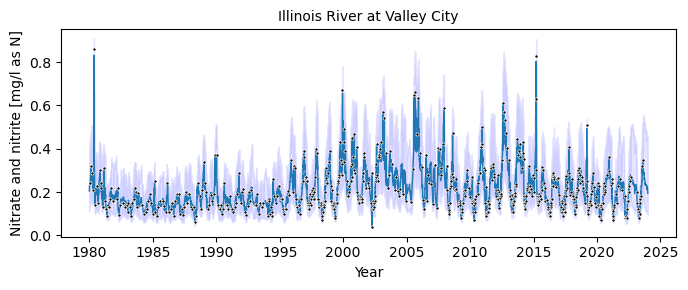

In [9]:
# plot result
fig, ax = plt.subplots(figsize=(7, 3))
model.plot(daily[["time", "flow"]], ax=ax)
ax.set_xlabel("Year")
# ax.set_xlim(auto=True)
ax.set_title("Illinois River at Valley City", size=10)
ax.set_ylabel("Nitrate and nitrite [mg/l as N]")
fig.tight_layout()
fig.savefig("illinois-river-nitrate.png")

/Users/thodson/micromamba/envs/discontinuum-dev/lib/python3.11/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:300: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(


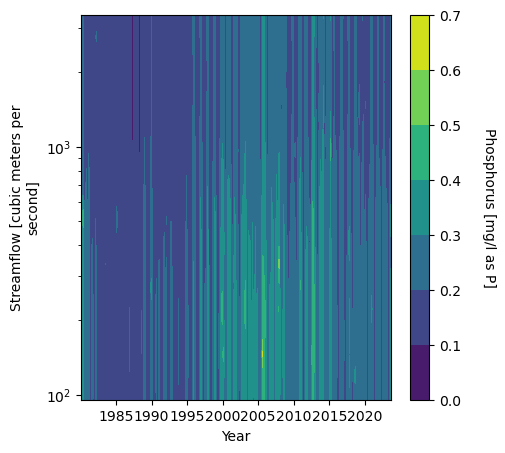

In [10]:
#  plot
model.contourf(levels=5)
plt.show()

In [51]:
# if that fails we might need to add prediction noise
# sim = model.sample(daily[['time','flow']], pred_noise=True)

In [52]:
# simulate concentration
sim_slice = daily[["time", "flow"]].sel(time=slice("1980", "2023"))

sim = model.sample(sim_slice)

In [53]:
# simulate flux
def to_flux(concentration, flow):
    flux = concentration * flow * 86400 * 1e-6
    flux.attrs = sim.attrs
    flux.attrs["units"] = "kilograms per day"
    flux.attrs["standard_name"] = "flux"
    return flux

In [54]:
import matplotlib.pyplot as plt


def plot_annual_sum(sim):
    """Describe"""
    fig, ax = plt.subplots()
    annual = sim.resample(time="YE").sum()
    annual.attrs["units"] = "kilograms per year"
    annual.attrs["short_name"] = "flux"

    annual.to_dataframe(name=annual.attrs["short_name"]).boxplot(by="time", showfliers=False, grid=False, ax=ax)
    ax.set_ylabel("{}\n[{}]".format(annual.attrs["long_name"], annual.attrs["units"]))
    ax.set_xlabel("Year")
    ax.tick_params(axis="x", labelrotation=90)

    labels = ["" if (year % 5 != 0) else year for i, year in enumerate(annual.time.dt.year.values)]
    ax.set_xticklabels(labels)
    ax.set_title("")
    # fig.suptitle('')
    return ax

<Axes: xlabel='Year', ylabel='Phosphorus\n[kilograms per year]'>

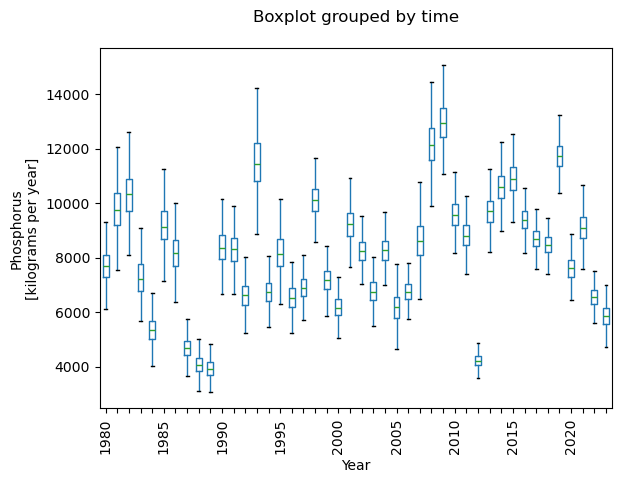

In [55]:
flux = to_flux(sim, sim_slice["flow"])
plot_annual_sum(flux)

In [56]:
# now let's create the pseudo-counterfactual
from discontinuum.utils import time_substitution

counterfactual = time_substitution(sim_slice, interval=slice("2005", "2005"))

In [57]:
counterfactual_sim = model.sample(counterfactual)
counterfactual_flux = to_flux(counterfactual_sim, sim_slice["flow"])

<Axes: xlabel='Year', ylabel='Phosphorus\n[kilograms per year]'>

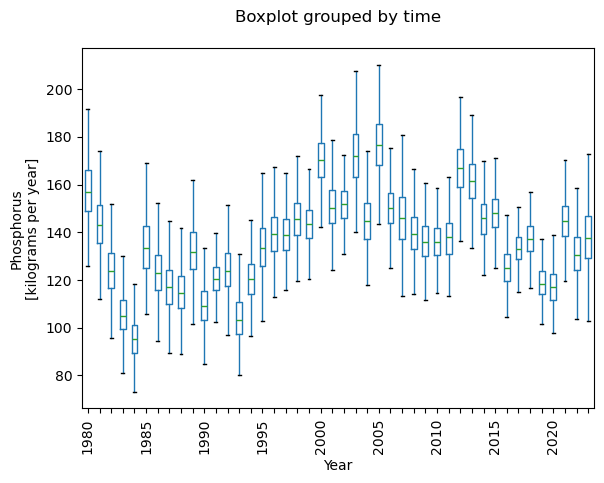

In [58]:
plot_annual_sum(counterfactual_sim)

In [59]:
annuals = counterfactual_flux.resample(time="YE").sum()

In [60]:
baseline = annuals.sel(time=slice("1980", "1996")).mean()

In [61]:
current = annuals.sel(time=slice("2019", "2023")).mean()

In [62]:
current / baseline

<xarray.DataArray ()> Size: 8B
array(1.10688782)